# Using Apache Drill to Query Parliament Written Questions Data

A bit of a play to try to get to grips with Apache Drill, querying over JSON and CSV for Parliament data that doesn't quite link up as it should do...

In [145]:
import pandas as pd
from pydrill.client import PyDrill

%matplotlib inline

#Get a connection to the Apache Drill server
drill = PyDrill(host='localhost', port=8047)

## Download Written Questions Data for a Session

This is a faff, because there is no bulk download...

It also makes more sense to use `requests-cache` along the way in case things break midway through the download, so you don't then have to reload everything again...

In [ ]:
#Get Written questions data - may take some time!
stub='http://lda.data.parliament.uk'.strip('/')

#We're going to have to call the API somehow
import requests


##To make thinks more efficient if we do this again, cache requests
#!pip3 install requests_cache
#import requests_cache
#requests_cache.install_cache('parlidata_cache', backend='sqlite')


#Get data from URL
def getURL(url):
    print(url)
    r=requests.get(url)
    print(r.status_code)
    return r

#Download data - if there is more, get it
def loader(url):
    items=[]
    done=False
    r=getURL(url)
    while not done:
        items=items+r.json()['result']['items']
        if 'next' in r.json()['result']:
            r=getURL(r.json()['result']['next']+'&_pageSize=500')
        else: done=True
    return items


url='{}/{}.json?session={}'.format(stub,'commonswrittenquestions','2015/16')
items=loader(url)


#Save the data
import json
with open('writtenQuestions.json', 'w') as outfile:
    json.dump(items, outfile)

We should now have all the data in a single JSON file (`writtenQuestions.json`).

(Actually, if we had downloaded the data into the same directory as separately and uniquely named JSON files, Apache Drill should be able to query over them...) 

Let's see if we can query it...

In [120]:
#What does the whole table look like?
q=''' SELECT * from dfs.`/Users/ajh59/Dropbox/parlidata/notebooks/writtenQuestions.json` LIMIT 3'''
drill.query(q).to_dataframe()

,AnswerDate,AnsweringBody,_about,dateTabled,questionText,tablingMember,tablingMemberPrinted,title,uin
0,"{""_value"":""2016-05-12"",""_datatype"":""dateTime""}","[{""_value"":""Prime Minister""}]",http://data.parliament.uk/resources/518530,"{""_value"":""2016-05-11"",""_datatype"":""dateTime""}","To ask the Prime Minister, if he will clarify ...","{""_about"":""http://data.parliament.uk/members/1...","[{""_value"":""Mr Keith Simpson""}]",House of Commons Tabled Parliamentary Question...,37017
1,"{""_value"":""2016-05-12"",""_datatype"":""dateTime""}","[{""_value"":""Department for Business, Innovatio...",http://data.parliament.uk/resources/518374,"{""_value"":""2016-05-10"",""_datatype"":""dateTime""}","To ask the Secretary of State for Business, In...","{""_about"":""http://data.parliament.uk/members/4...","[{""_value"":""Ms Angela Eagle""}]",House of Commons Tabled Parliamentary Question...,36951
2,"{""_value"":""2016-05-12"",""_datatype"":""dateTime""}","[{""_value"":""Department for Business, Innovatio...",http://data.parliament.uk/resources/518375,"{""_value"":""2016-05-10"",""_datatype"":""dateTime""}","To ask the Secretary of State for Business, In...","{""_about"":""http://data.parliament.uk/members/4...","[{""_value"":""Ms Angela Eagle""}]",House of Commons Tabled Parliamentary Question...,36970


In [40]:
#Try to select a column
q='''
SELECT j.tablingMember._about AS memberURL 
FROM dfs.`/Users/ajh59/Dropbox/parlidata/notebooks/writtenQuestions.json` j LIMIT 3
'''
drill.query(q).to_dataframe()


,memberURL
0,http://data.parliament.uk/members/126
1,http://data.parliament.uk/members/491
2,http://data.parliament.uk/members/491


In [41]:
#Try to select an item from a list in a column
q='''
SELECT tablingMemberPrinted[0]._value AS Name 
FROM dfs.`/Users/ajh59/Dropbox/parlidata/notebooks/writtenQuestions.json` LIMIT 3
'''
drill.query(q).to_dataframe()


,Name
0,Mr Keith Simpson
1,Ms Angela Eagle
2,Ms Angela Eagle


In [58]:
#Get a dataframe of all the member URLs - so we can get the data fro each from the Parliament data API
q='''
SELECT DISTINCT j.tablingMember._about AS memberURL 
FROM dfs.`/Users/ajh59/Dropbox/parlidata/notebooks/writtenQuestions.json` j
'''
memberIds = drill.query(q).to_dataframe()
memberIds.head()


,memberURL
0,http://data.parliament.uk/members/126
1,http://data.parliament.uk/members/491
2,http://data.parliament.uk/members/4058
3,http://data.parliament.uk/members/4405
4,http://data.parliament.uk/members/1604


In [53]:
#The URLs in the written question data donlt actually resolve - we need to tweak them
#Generate a set of members who have tabled questions that have been answered
#Note that the identifier Linked Data URL doesn't link... so patch it...
members= ['{}.json'.format(i.replace('http://','http://lda.')) for i in memberIds['memberURL']]

#Preview the links
members[:3]

['http://lda.data.parliament.uk/members/126.json',
 'http://lda.data.parliament.uk/members/491.json',
 'http://lda.data.parliament.uk/members/4058.json']

In [ ]:
#Download the data files into a data directory
!mkdir -p data/members
for member in members:
    !wget -quiet -P data/members {member}

In [55]:
!ls data/members

103.json  1511.json 234.json  3987.json 4088.json 4367.json 4433.json 4500.json
104.json  1516.json 242.json  3989.json 4090.json 4368.json 4434.json 4501.json
112.json  1518.json 245.json  3990.json 4091.json 4369.json 4435.json 4502.json
114.json  1521.json 249.json  3991.json 4092.json 437.json  4436.json 4503.json
116.json  1522.json 253.json  3992.json 4093.json 4370.json 4437.json 4504.json
117.json  1524.json 261.json  3994.json 4099.json 4371.json 4438.json 4505.json
1171.json 1527.json 280.json  3997.json 410.json  4372.json 4440.json 4506.json
12.json   1533.json 288.json  3998.json 4100.json 4374.json 4441.json 4507.json
1200.json 1536.json 296.json  3999.json 4103.json 4375.json 4442.json 4508.json
1211.json 1537.json 298.json  40.json   4104.json 4376.json 4443.json 4509.json
126.json  1538.json 301.json  400.json  4108.json 4377.json 4444.json 451.json
1383.json 1540.json 304.json  4000.json 4109.json 4378.json 4445.json 4510.json
1384.json 1541.json 307.json  4003.json 4

In [56]:
#Preview one of the files
!head data/members/1474.json

{ "format" : "linked-data-api", "version" : "0.2", "result" : {"_about" : "http://lda.data.parliament.uk/members/1474.json", "definition" : "http://lda.data.parliament.uk/meta/members/_id.json", "extendedMetadataVersion" : "http://lda.data.parliament.uk/members/1474.json?_metadata=all", "primaryTopic" : {"_about" : "http://data.parliament.uk/members/1474", "constituency" : {"_about" : "http://data.parliament.uk/resources/147335", "label" : {"_value" : "Ynys Môn"}
      }
      , "familyName" : {"_value" : "Owen"}
      , "fullName" : {"_value" : "Albert Owen"}
      , "gender" : {"_value" : "Male"}
      , "givenName" : {"_value" : "Albert"}
      , "homePage" : "http://albertowenmp.org/", "isPrimaryTopicOf" : "http://lda.data.parliament.uk/members/1474.json", "label" : {"_value" : "Biography information for Albert Owen"}
      , "party" : {"_value" : "Labour"}
      , "twitter" : {"_value" : "https://twitter.com/AlbertOwenMP"}
    }


Apache Drill can query over multiple files in the same directory, so let's try that...

Query over all the downloaded member JSON files to create a dataframe to pull out the gender for each member ID URL.

In [115]:
q=''' SELECT j.`result`.primaryTopic.gender._value AS gender,
j.`result`._about AS url
FROM dfs.`/Users/ajh59/Dropbox/parlidata/notebooks/data/members` j'''
membersdf=drill.query(q).to_dataframe()
membersdf.head()

,gender,url
0,Male,http://lda.data.parliament.uk/members/103.json
1,Male,http://lda.data.parliament.uk/members/104.json
2,Male,http://lda.data.parliament.uk/members/112.json
3,Male,http://lda.data.parliament.uk/members/114.json
4,Male,http://lda.data.parliament.uk/members/116.json


Now we need to remap those URLs onto URLs of the form used in the Written Questions data.

In [117]:
#Lets reverse the URL to the same form as in the written questions - then we can use this for a JOIN
membersdf['fixedurl']=membersdf['url'].str.replace('http://lda.','http://').str.replace('.json','')
#Save the data as a CSV file
membersdf.to_csv('data/members.csv',index=False)
!head data/members.csv

gender,url,fixedurl
Male,http://lda.data.parliament.uk/members/103.json,http://data.parliament.uk/members/103
Male,http://lda.data.parliament.uk/members/104.json,http://data.parliament.uk/members/104
Male,http://lda.data.parliament.uk/members/112.json,http://data.parliament.uk/members/112
Male,http://lda.data.parliament.uk/members/114.json,http://data.parliament.uk/members/114
Male,http://lda.data.parliament.uk/members/116.json,http://data.parliament.uk/members/116
Male,http://lda.data.parliament.uk/members/117.json,http://data.parliament.uk/members/117
Male,http://lda.data.parliament.uk/members/1171.json,http://data.parliament.uk/members/1171
Female,http://lda.data.parliament.uk/members/12.json,http://data.parliament.uk/members/12
Male,http://lda.data.parliament.uk/members/1200.json,http://data.parliament.uk/members/1200


## Querying Over JOINed JSON and CSV Files

Let's see if we can now run a query over the joined monolithic wirtten questions JSON data file and the members CSV data file we created.

In [119]:
#Now find the gender of a question asker - join a query over the monolithic JSON file with the CSV file
q=''' SELECT DISTINCT j.tablingMember._about AS memberURL, m.gender
FROM dfs.`/Users/ajh59/Dropbox/parlidata/notebooks/writtenQuestions.json` j 
JOIN dfs.`/Users/ajh59/Dropbox/parlidata/notebooks/data/members.csv` m
ON j.tablingMember._about = m.fixedurl
LIMIT 3'''
drill.query(q).to_dataframe()

,gender,memberURL
0,Male,http://data.parliament.uk/members/126
1,Female,http://data.parliament.uk/members/491
2,Male,http://data.parliament.uk/members/4058


## JOINing Across A Monolithic JSON file and a Directory of Files with Regularly Mismatched Keys

That's a clunky route round though... Can we actually do a JOIN between the monolithc written answers JSON file and the separate members JSON files, hacking the member ID URL into the correct form as part of the ON condition?

In [125]:
#Let's see if we can modify the URL in the spearate JSON files so we can join with the monolithic file
q=''' SELECT DISTINCT j.tablingMember._about AS memberURL,
m.`result`.primaryTopic.gender._value AS gender,
m.`result`._about AS url
FROM dfs.`{path}/writtenQuestions.json` j 
JOIN dfs.`{path}/data/members` m
ON j.tablingMember._about = REGEXP_REPLACE(REGEXP_REPLACE(m.`result`._about,'http://lda.','http://'),'\.json','')
LIMIT 3'''.format(path='/Users/ajh59/Dropbox/parlidata/notebooks')
drill.query(q).to_dataframe()


,gender,memberURL,url
0,Male,http://data.parliament.uk/members/126,http://lda.data.parliament.uk/members/126.json
1,Female,http://data.parliament.uk/members/491,http://lda.data.parliament.uk/members/491.json
2,Male,http://data.parliament.uk/members/4058,http://lda.data.parliament.uk/members/4058.json


Now let's do some counting... in the session for which we downloaded the data, how many written questions were tabled by gender, in total?

In [126]:
q=''' SELECT COUNT(*) AS Number,
m.`result`.primaryTopic.gender._value AS gender
FROM dfs.`{path}/writtenQuestions.json` j 
JOIN dfs.`{path}/data/members` m
ON j.tablingMember._about = REGEXP_REPLACE(REGEXP_REPLACE(m.`result`._about,'http://lda.','http://'),'\.json','')
GROUP BY m.`result`.primaryTopic.gender._value'''.format(path='/Users/ajh59/Dropbox/parlidata/notebooks')
drill.query(q).to_dataframe()


,Number,gender
0,25573,Male
1,11605,Female


How many per person, by gender?

In [131]:
q=''' SELECT COUNT(*) AS Number, j.tablingMemberPrinted[0]._value AS Name,
m.`result`.primaryTopic.gender._value AS gender
FROM dfs.`{path}/writtenQuestions.json` j 
JOIN dfs.`{path}/data/members` m
ON j.tablingMember._about = REGEXP_REPLACE(REGEXP_REPLACE(m.`result`._about,'http://lda.','http://'),'\.json','')
GROUP BY m.`result`.primaryTopic.gender._value, j.tablingMemberPrinted[0]._value 
'''.format(path='/Users/ajh59/Dropbox/parlidata/notebooks')

drill.query(q).to_dataframe().head()

,Name,Number,gender
0,Mr Keith Simpson,2,Male
1,Ms Angela Eagle,41,Female
2,Paul Blomfield,222,Male
3,Julie Cooper,194,Female
4,Mr Virendra Sharma,123,Male


Can we do the average too?

In [134]:
q='''
SELECT AVG(Number) AS average, gender
FROM (SELECT COUNT(*) AS Number, j.tablingMemberPrinted[0]._value AS Name,
    m.`result`.primaryTopic.gender._value AS gender
    FROM dfs.`{path}/writtenQuestions.json` j 
    JOIN dfs.`{path}/data/members` m
    ON j.tablingMember._about = REGEXP_REPLACE(REGEXP_REPLACE(m.`result`._about,'http://lda.','http://'),'\.json','')
    GROUP BY m.`result`.primaryTopic.gender._value, j.tablingMemberPrinted[0]._value )
GROUP BY gender
'''.format(path='/Users/ajh59/Dropbox/parlidata/notebooks')

drill.query(q).to_dataframe()

,average,gender
0,68.5603217158177,Male
1,69.49101796407186,Female


How about by party?

In [143]:
q='''
SELECT AVG(Number) AS average, party
FROM (SELECT COUNT(*) AS Number, j.tablingMemberPrinted[0]._value AS Name,
    m.`result`.primaryTopic.party._value AS party
    FROM dfs.`{path}/writtenQuestions.json` j 
    JOIN dfs.`{path}/data/members` m
    ON j.tablingMember._about = REGEXP_REPLACE(REGEXP_REPLACE(m.`result`._about,'http://lda.','http://'),'\.json','')
    GROUP BY m.`result`.primaryTopic.party._value, j.tablingMemberPrinted[0]._value )
GROUP BY party
'''.format(path='/Users/ajh59/Dropbox/parlidata/notebooks')

dq=drill.query(q).to_dataframe()
dq['average']=dq['average'].astype(float)
dq

,average,party
0,35.646288,Conservative
1,100.336683,Labour
2,135.125000,Liberal Democrat
3,198.000000,Democratic Unionist Party
4,103.041667,Labour (Co-op)
5,49.293103,Scottish National Party
6,185.000000,UK Independence Party
7,28.500000,Independent
8,36.666667,Plaid Cymru
9,71.666667,Social Democratic & Labour Party


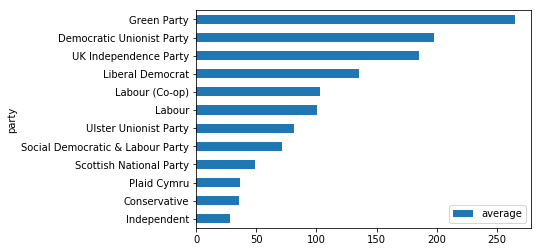

In [150]:
dq.set_index('party').sort_values(by='average').plot(kind="barh");

Party and gender?

In [152]:
q='''
SELECT AVG(Number) AS average, party, gender
FROM (SELECT COUNT(*) AS Number, j.tablingMemberPrinted[0]._value AS Name,
    m.`result`.primaryTopic.party._value AS party,
    m.`result`.primaryTopic.gender._value AS gender
    FROM dfs.`{path}/writtenQuestions.json` j 
    JOIN dfs.`{path}/data/members` m
    ON j.tablingMember._about = REGEXP_REPLACE(REGEXP_REPLACE(m.`result`._about,'http://lda.','http://'),'\.json','')
    GROUP BY m.`result`.primaryTopic.party._value, m.`result`.primaryTopic.gender._value, j.tablingMemberPrinted[0]._value )
GROUP BY party, gender
'''.format(path='/Users/ajh59/Dropbox/parlidata/notebooks')

dq=drill.query(q).to_dataframe()
dq['average']=dq['average'].astype(float)
dq

,average,gender,party
0,36.918478,Male,Conservative
1,91.453488,Female,Labour
2,107.097345,Male,Labour
3,135.125000,Male,Liberal Democrat
4,198.000000,Male,Democratic Unionist Party
5,30.444444,Female,Conservative
6,109.700000,Female,Labour (Co-op)
7,55.815789,Male,Scottish National Party
8,185.000000,Male,UK Independence Party
9,36.900000,Female,Scottish National Party


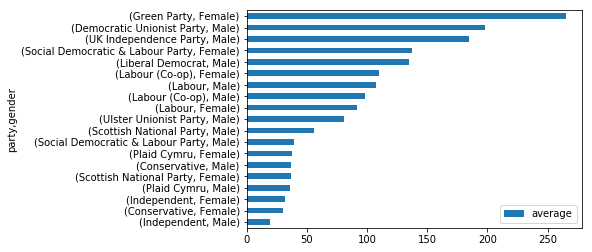

In [153]:
dq.set_index(['party','gender']).sort_values(by='average').plot(kind="barh");

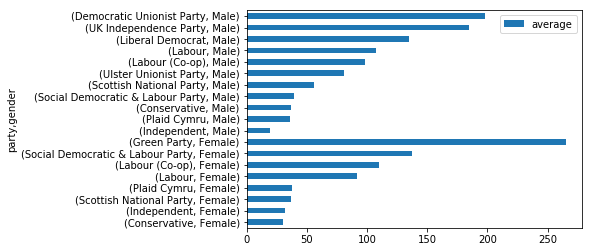

In [161]:
dq.sort_values(by=['gender','average']).set_index(['party','gender']).plot(kind="barh");

In [169]:
dqp=dq.pivot(index='party',columns='gender')
dqp.columns = dqp.columns.get_level_values(1)
dqp

gender,Female,Male
party,,
Conservative,30.444444,36.918478
Democratic Unionist Party,NaN,198.000000
Green Party,265.000000,NaN
Independent,31.666667,19.000000
Labour,91.453488,107.097345
Labour (Co-op),109.700000,98.285714
Liberal Democrat,NaN,135.125000
Plaid Cymru,38.000000,36.000000
Scottish National Party,36.900000,55.815789


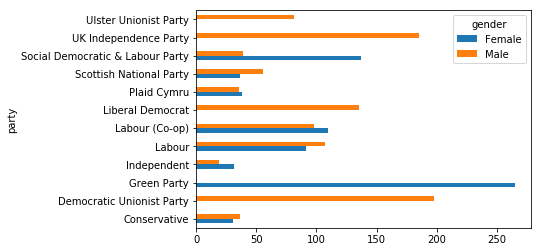

In [171]:
dqp.plot(kind='barh');